# Yelp API Webscraping

Yelp is an online service combining crowd-sourced reviews with yellow-page-like business directory information. Since its inception in 2004, the service has amassed 192 million reviews across 4.6 million active local businesses [[source](https://www.yelp-ir.com/overview/default.aspx)]. Our project will focus on using Yelp's business data to predict local census information--specifically, whether or not the relative price point of a business is useful for predicting the average affluence of an area. 

Yelp's Fusion service, a REST API, allows us to have read-only access to Yelp's data. Yelp Fusion is free (with limitations) and only requires a Yelp account with valid e-mail address.

## Before using this notebook:

To get started, we obtain an API key according to the directions [here](https://www.yelp.com/developers/faq). Once you obtain the API key, store it in a `.json` file which contains only the following text:

```
{"api": "your api key"}
```

...where "your api key" is your actual API key wrapped in double quotes. We have set up the notebook to access the file stored in `../Assets/creds.json`. You may organize your project (and therefore modify this code) to have a different folder structure.  

**Important:** Since the API key is confidential and can be linked to a client's financial records, include the `creds.json` file in `.gitignore`.

## Import relevant libraries

In [154]:
import json, requests                   # to use our API
import math                             # for our geocoordinate functions
import time                             # to save our files with timestamps
import pandas as pd                     # to save our business listings as a DataFrame
import matplotlib.path as mplpath       # for gathering coordinates inside LA

# for making visualizations
import folium                           
from collections import defaultdict

## Set up global variables to use Fusion API

In [12]:
'''NOTHING IN THIS CELL NEEDS TO GET CHANGED IF YOU HAVE YOUR API KEY 
located in ../Assets/creds.json

The text in your .json file will be a single dictionary containing api key with 
DOUBLE QUOTES

{"api": "your api key"}
'''

CREDS_FILE = open('../Assets/creds.json')

# load credentials into variable
YELP_CREDENTIALS = json.loads(CREDS_FILE.read())
API_KEY = YELP_CREDENTIALS['api']
HEADERS = {'Authorization': 'Bearer %s' % API_KEY}

# this is the url we use to make broad business searches
# https://www.yelp.com/developers/documentation/v3/business_search

URL = 'https://api.yelp.com/v3/businesses/search'

### Issues that arise from the limitations of the free version of Fusion:

For a sufficiently wide search query, one could imagine receiving thousands of business listings. However, the free version of Yelp Fusion has several limitations:

- Each API request returns a maximum of 50 business listings.
    - one can get around this by setting the "offset" to 50, 100, etc. to get 51-100, 101-150, etc.
- For any given search query, the Fusion API limits its results to 1000.
    - Despite this, Yelp will return the total number of businesses that match the given search query (eg 3200) under the "total" key. However, collecting listings with an offset of 1000 will result in an error.
- Searching by ZIP code will likely result in over 1000 listings in business-dense or very large areas. This means that it would be impossible to get complete results using this method.
- Searching by coordinate / radius would be more complete, but given that circles do not pack the same way squares do, we must focus on the most efficient way of arranging circles so that they cover a given area.  
    - hexagonal packing seems to be the most straightforward and efficient way to do so.
    
### Our solution: 

We first sweep across LA county grabbing equally-spaced latitude and longitude coordinates that fall within county lines. At each coordinate, we run a search query; if the query results in up to 1000 listings, we iterate through the `offset` parameter to collect the total amount. In cases where a specific search query will return more than 1000 listings, we split the circle described by the `radius` parameter into 7 smaller, hexagonally arranged circles, and run 7 new searches based on the modified coordinates and radii. If any of these circles still return more than 1000 listings, they are then split into 7 smaller circles, with no limitation to the splitting depth.

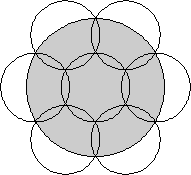

## Function Walkthrough

- `la_county_yelp_scanner()`
    - `get_la_county_points()`
    - `get_businesses()`
        - `call_and_delay()`
        - `add_businesses()`
        - `shotgun()`
            - `get_six_points()`
                - `get_earth_radius()`
                - `get_new_point()`
            - `get_businesses()`
            
### `la_county_yelp_scanner()`
This is the main function that gets all listings in LA County and returns a dataframe and csv containing listing information.

### `get_la_county_points()`
This function calculates all hexagonally-arranged latitude and longitude coordinates that fall within the LA county border, optimized for a specific search radius, in meters.

### `get_businesses()`
For each point in `get_la_county_points()`, this function uses: 
- `call_and_delay()`, which calls the API and adds a delay to prevent exceeding the query-per-second (QPS) limit, and
- `add_businesses()` to add the API response from `call_and_delay()` to a list container.  

If total number of listings in the given search area exceeds 1000, then it calls `shotgun()` instead.

### `shotgun()`
This function splits a search area into seven smaller search areas with identical radii. Uses:
- `get_six_points()`, which repeats `get_earth_radius()` and `get_new_point()` six times:
    - since the Earth is not _quite_ spherical, we use ideal oblate spheroid geometry to `get_earth_radius()`. It probably doesn't make a huge difference, but we may as well be thorough.
    - given `get_earth_radius()`, we use `get_new_point()` to calculate destination coordinates depending on our starting coordinates, the distance traveled on the surface, and the direction traveled.
    - referencing the 7-disk schematic in the above section and using geometry of equilateral triangles, we can calculate that for the shaded circle of radius $r$, each smaller circle has a radius $\frac{r}{2}$ and the centers of each of the circles are $\frac{\sqrt{3}}{2}r$ apart.
- `get_businesses()` for each of the seven smaller circles.

Because `get_businesses()` and `shotgun()` call each other, this process can be iterated any number of times in order to get the total results at 1000 or below.

### latitude-longitude functions

In [13]:
# https://en.wikipedia.org/wiki/Earth_radius

def get_earth_radius(lat):
    '''
    Calculates radius of Earth at given latitude, assuming 
    oblate spheroid geometry.
    
    Arguments:
        lat (float):        latitude, in decimal degrees
        
    Returns:
        radius (float), in meters
    '''
    
    lat = math.radians(lat)
    
    # geocentric radius formula
    a = 6_378_137               # equatorial radius
    b = 6_356_752.3             # polar radius
    numer = (a**2 * math.cos(lat))**2 + (b**2 * math.sin(lat))**2
    denom = (a * math.cos(lat))**2 + (b * math.sin(lat))**2
    
    return math.sqrt(numer / denom) 

In [14]:
def get_new_point(distance, bearing, lon=0, lat=0):
    '''
    Generates destination geographic coordinate based on 
    starting point, spherical distance traveled, and bearing.
    Use only for short distances (< 100_000).
    
    Arguments:
        distance (float):   distance to closest point, in meters
        bearing (float):    direction from starting point, in decimal degrees
        lat (float):        starting latitude, in decimal degrees
        lon (float):        starting longitude, in decimal degrees
        
    Returns:
        tuple containing new coordinates, in decimal degrees
        
    Function dependencies:
        get_earth_radius()
    '''
    er = get_earth_radius(lat)
    
    # converting to radians
    bearing = math.radians(bearing)
    lat     = math.radians(lat)
    lon     = math.radians(lon)
    
    # formulae taken from https://www.movable-type.co.uk/scripts/latlong.html
    lat2 = math.asin(math.sin(lat) * math.cos(distance / er)
           + math.cos(lat) * math.sin(distance / er) * math.cos(bearing))
    
    lon2 = lon + math.atan2(
           math.sin(bearing) * math.sin(distance / er) * math.cos(lat),
           math.cos(distance / er) - math.sin(lat) * math.sin(lat2))
    
    return math.degrees(lon2), math.degrees(lat2)

In [132]:
# picking seven smaller circles to "equal" one big circle
# https://en.wikipedia.org/wiki/Haversine_formula
# https://stackoverflow.com/questions/639695/
# https://stackoverflow.com/questions/7222382/
# https://www2.stetson.edu/~efriedma/circovcir/

def get_six_points(distance, lon=0, lat=0, rot=0):
    '''
    Generates 6 additional geographic coordinates hexagonally 
    arranged some distance from starting point.
    
    Arguments:
        distance (float):   distance to closest point, in meters
        lat1 (float):       starting latitude, in decimal degrees
        lon1 (float):       starting longitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        list of dictionaries with {'latitude': lat2, 'longitude': lon2}, 
        excluding starting point
        
    Function dependencies:
        get_new_point()
        get_earth_radius()
    '''    
    points = []
    
    # six directions
    bearings = list(range(rot, rot + 360, 60))

    for bearing in bearings:
        point = {}
        lon2, lat2 = get_new_point(distance, bearing, lon=lon, lat=lat)
        point['longitude'] = lon2
        point['latitude'] = lat2
        points.append(point)

    return points

In [70]:
# https://gis.stackexchange.com/questions/183248/

def get_la_county_points(radius):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to optimize for,
                            in meters
        
    Returns:
        a list containing hexagonally arranged coordinates
        to search over
    '''
    distance = radius * math.sqrt(3)
    
    # loads padded county bounds
    # http://polygons.openstreetmap.fr/index.py?id=396479
    county_bounds = json.loads(open('../Assets/la_county_coordinates_20-10-10.json').read())
    bounds = county_bounds['geometries'][0]['coordinates'][0][0]
    # path for matplotlib method
    boundary = mplpath.Path(bounds)
    
    LATMIN = min([ele[1] for ele in bounds])
    LATMAX = max([ele[1] for ele in bounds])
    
    LONMIN = min([ele[0] for ele in bounds])
    LONMAX = max([ele[0] for ele in bounds])
    
    # start at "upper-left" corner of rectangle that circumscribes LA county
    # offset it by a small amount to ensure our first points are "inside"
    lat = LATMAX
    lon = LONMIN
    
    lon, lat = get_new_point(radius, 135, lon=lon, lat=lat)
    
    points = [[lon, lat]]
    
    # we will "scan" the rectangle from left-to-right, top-to-bottom
    
    # if we haven't reached the bottom yet
    while lat > LATMIN:
        
        # here to start the scan at the beginning of each latitude
        startlat = lat
        startlon = lon
        
        # if we haven't reached the right yet
        while lon < LONMAX:
            # scan to the right
            lon, lat = get_new_point(distance, 90, lon=lon, lat=lat)
            points.append([lon,lat])
        
        # offset the next row for optimal hexagonal packing
        lon, lat = get_new_point(distance, 210, lon=startlon, lat=startlat)
        
        # if we are outside the border of LA county
        if lon < LONMIN:
            lon, lat = get_new_point(distance, 150, lon=startlon, lat=startlat)
            
        # add the point
        points.append([lon,lat])
        
    # boolean mask if the points in our rectangle are within LA county
    inside = boundary.contains_points(points)
    
    new_points = []
    
    # if true, add to newpoints
    for i, ins in enumerate(inside):
        if ins:
            new_points.append(points[i])
        
    return new_points

In [151]:
# https://morioh.com/p/d896544d6977

county_bounds = json.loads(open('../Assets/la_county_coordinates.json').read())

la_map = folium.Map(location=[34.3390, -118.2359], zoom_start=10)
folium.GeoJson(county_bounds).add_to(la_map)

points = get_la_county_points(4000)

for point in points:
    folium.CircleMarker((point[1], point[0]), 
                        radius=31, 
                        weight=1, 
                        color='red', 
                        fill_color='red').add_to(la_map)

la_map.save('../Assets/la_coordinate_map.html')

![image](../Assets/get_la_county_points_4000.png)

We chose a radius of 4000 meters as a round number which allowed for the majority of LA county to be covered. While there are some portions of the county not covered by the function (notably on the NE corner and some of the western edges), these areas are uninhabited do not have commercial activity.

### individual action functions

In [158]:
def add_businesses(response, business_list):
    '''
    Adds businesses to a list container.
    Not designed to be used alone.
    
    Arguments:
        response:       the API request object
        business_list:  an empty (or existing) list container
        
    Returns:
        the modified list container
    '''
    # businesses are listed under 'businesses' key
    businesses_obj = response.json()['businesses']

    for i, business in enumerate(list(businesses_obj)):

    # each dictionary will contain all of the desired information
    # from each business
        business_dict = {}
        
        # only grab business info if price is listed
        if 'price' in businesses_obj[i].keys():
            business_dict['id']           = business['id']
            business_dict['latitude']     = business['coordinates']['latitude']
            business_dict['longitude']    = business['coordinates']['longitude']
            business_dict['price']        = business['price']
            business_dict['review_count'] = business['review_count']
            business_dict['rating']       = business['rating']
            business_dict['zip_code']     = business['location']['zip_code']
            business_dict['city']         = business['location']['city']
            business_dict['alias']        = business['alias']

            num_categories = len(businesses_obj[i]['categories'])
            category_list = []
            for j in range(num_categories):
                category = businesses_obj[i]['categories'][j]['alias']
                category_list.append(category)
                business_dict['category'] = category_list
            
            business_list.append(business_dict)
        
    return business_list

In [73]:
def call_and_delay(url, headers, params, sleep=0.25):
    '''
    Calls the API and induces a delay to reduce QPS.
    
    Arguments:
        url:            url of API
        headers:        headers, which includes API key
        params:         dictionary of parameters of search
        sleep:          induced delay, in seconds
                        (estimated max QPS of five per second)
        
    Returns:
        the response object from the API call
    '''
    response = requests.get(url, headers=headers, params=params)
    time.sleep(sleep)
    
    code = response.status_code
    
    # if things go well
    if code == 200:
        return response
    
    # if things don't go well
    else:
        print(f'! ! ! ! ! ! ! ! ! ! ! ! error code {response.status_code} ! ! ! ! ! ! ! ! ! ! ! !')
        # code of 429 means our daily limit has been reached
        # {429} interrupts the function upstream
        if code == 429:
            return 429
        
        # we can usually get around other errors by waiting
        elif (code >= 500):
            time.sleep(5)
            response = requests.get(url, headers=headers, params=params)
            time.sleep(sleep)
            return response
        
        # don't attempt to add businesses if we throw other errors
        else:
            time.sleep(5)
            pass

In [114]:
def get_businesses(radius, lon=0, lat=0, sleep=0.25, layer=0):
    '''
    Grabs as many businesses as allowed by the Yelp API given 
    geographic coordinates and search radius.
    
    Arguments:
        radius (float):     search radius, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        layer (int):        only here to format the print output
                            of the scanner. changes aren't necessary.
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # for formatting
    layer += 1
    bar = '===' * layer
    
    # Yelp doesn't like float radii
    radius = int(radius)
    
    # empty container to hold businesses
    businesses = []
    
    params = {
        'limit': 50, 
        'latitude': lat,
        'longitude': lon,
        'radius': radius,
        'offset': 0,
        'sort_by': 'distance'
    }

    # call the API
    response = call_and_delay(URL, HEADERS, params, sleep=sleep)
    
    # if we reach our max daily API limit, interrupt parent function
    if response == 429:
        return 429
    
    total = response.json()['total']
    
    # if search query exceeds 1000 max, initiate shotgun()
    if total > 1000:
        print(f'caution: query returns approximately {round(total, -2)} listings.')
        businesses = shotgun(radius, lon=lon, lat=lat, sleep=sleep, layer=layer)
        return businesses
    
    # gather info normally
    else:
        # add the first n <= 50 businesses
        add_businesses(response, businesses)
        
        # loop through offsets
        if total > 50:
        
            # only loop through offsets to the total number of listings
            for offset in range(50, total, 50):
                # update offset in search parameters
                params['offset'] = offset
                response = call_and_delay(URL, HEADERS, params, sleep)

                add_businesses(response, businesses)

                # just a little sanity check
                if offset % 100 == 0:
                    print(f'{bar} {offset} out of {total}')
            
        print(f'{bar} sub-search of {total} listings finished!')
        return businesses

### aggregate functions

In [150]:
def shotgun(radius, lon=0, lat=0, rot=0, sleep=0.25, layer=1):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to emulate, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        a list containing dictionaries of each business listing
    '''
    # for formatting
    bar = '===' * layer
    
    businesses = []
    
    rot = rot + ((layer % 2) * 30 - 30)
    
    # initiate list of points to search
    points = [{'longitude': lon, 'latitude': lat}]
    
    # see appendix for an explanation
    distance = radius * math.sqrt(3) / 2
    points.extend(get_six_points(distance, 
                                 lon=lon, 
                                 lat=lat, 
                                 rot=rot))
    small_radius = distance / math.sqrt(3)
    
    print('attempting shotgun')

    # loop through each of the seven points using the smaller radius
    for i, point in enumerate(points):
        # to show which subradius we are searching through
        print(f'{bar} {i+1} of {len(points)}')
        pellet = get_businesses(small_radius,
                                lon=point['longitude'], 
                                lat=point['latitude'], 
                                sleep=sleep, 
                                layer=layer)
        businesses.extend(pellet)

    return businesses

In [76]:
# https://stackoverflow.com/questions/9427163/

def remove_duplicates(list_of_dictionaries):
    '''
    Removes duplicate dictionaries in the businesses list 
    by matching business ID.
    
    Arguments:
        list_of_dictionaries:       the list containing 
                                    business dictionaries
        
    Returns:
        a modified list without duplicate entries
    '''    
    # a set ignores duplicates
    seen = set()
    new_list = []
    
    for dictionary in list_of_dictionaries:
        # grab the id
        i = dictionary['id']
        
        # if we haven't seen the id yet, add it to the set
        if i not in seen:
            seen.add(i)
            # and then add the dictionary to the new list
            new_list.append(dictionary)
            
    # otherwise, we ignore
    print(f'{len(new_list)} unique listings from {len(list_of_dictionaries)} aggregated results')
    return new_list

In [77]:
def la_county_yelp_scanner(radius, save=True, start=0, end=-1, sleep=0.25):
    '''
    Grabs listings from a set of coordinates within LA county.
    
    Arguments:
        radius (float):     search radius, in meters
        start (int):        where to start our loop
        end (float):        where to end our loop
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # just because it takes such a long time
    start_time = time.time()
    
    # grab all the points within LA county
    points = get_la_county_points(radius)
    num_points = len(points)
    
    if start < 0:
        start = 0
    elif start < 1:
        start = int(start * num_points)
    else:
        start = int(start)
    
    if end < 0:
        end = len(points)
    elif end < 1:
        end = int(end * num_points)
    else:
        end = int(end)
        
    if start > end:
        end = start + end
    
    if end > num_points:
        end = num_points
        
    print(f'''
            ==================================================================
            
            gathering listings from {num_points} coordinates in LA county
            
            ==================================================================            
            ''')
    
    businesses = []
    error_tracker = None
    
    for i in range(start, end):
        
        if i % int(num_points / 10) == 0:
            print(f'============ {i} out of {num_points} ============')
        
        point = points[i]
        
        # points are [longitude, latitude]
        b = get_businesses(radius, lon=point[0], lat=point[1], sleep=sleep)
        
        # there is a high chance we will reach our max call limit
        # with this function. for that reason, we wanted to add an
        # option to resume the function using another API key.
        if b == 429:
            error_tracker = {'radius': radius, 'error_info': {}}
            error_tracker['error_info']['marker']    = start + i
            error_tracker['error_info']['latitude']  = point[0]
            error_tracker['error_info']['longitude'] = point[1]
            error_tracker['error_info']['sleep']     = sleep
            
            print(f'''
            ==================================================================
            
            use another API key to re-run the code with the following arguments:
            
            la_county_yelp_scanner({radius}, start={start + i}, end={end}, sleep={sleep})
            
            ==================================================================            
            ''')
            
            return businesses, error_tracker
        
        # adds businesses if things go well
        businesses.extend(b)
    
    # removes duplicate entries from overlapping search queries
    businesses = remove_duplicates(businesses)
    
    if len(businesses) == 0:
        print('please consider widening your search parameters.')
    
    else:        
        businesses = pd.DataFrame(businesses)

        # Saves the business dataframe to a csv file with current time
        if save:
            now_formatted = time.strftime("%Y-%m-%d_%H_%M")
            businesses_path = f'../data/{radius}_{start}_{end}_businesses{now_formatted}.csv'
            businesses.to_csv(businesses_path,index=False)
            
        end_time = time.time()
        elapsed = end_time - start_time

        print(f'elapsed time: {round(elapsed / 60, 1)} min.')
        print(f'overall efficiency: {round(elapsed / len(businesses) * 1000, 1)} seconds per 1000 listings.')

        return businesses, error_tracker

In [159]:
b, e = la_county_yelp_scanner(4000, start=0, end=-1, sleep=0.3)


            
            gathering listings from 287 coordinates in LA county
            
            
============ 0 out of 287 ============
=== sub-search of 26 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 1 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 2 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 19 listings finished!
=== sub-search of 3 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 2 listings finished!
=== sub-search of 1 listings finish

=== 700 out of 898
=== 800 out of 898
=== sub-search of 898 listings finished!
=== 100 out of 540
=== 200 out of 540
=== 300 out of 540
=== 400 out of 540
=== 500 out of 540
=== sub-search of 540 listings finished!
=== 100 out of 402
=== 200 out of 402
=== 300 out of 402
=== 400 out of 402
=== sub-search of 402 listings finished!
=== 100 out of 372
=== 200 out of 372
=== 300 out of 372
=== sub-search of 372 listings finished!
=== 100 out of 219
=== 200 out of 219
=== sub-search of 219 listings finished!
=== sub-search of 49 listings finished!
=== sub-search of 5 listings finished!
=== sub-search of 0 listings finished!
=== sub-search of 5 listings finished!
=== sub-search of 6 listings finished!
=== sub-search of 1 listings finished!
=== 100 out of 224
=== 200 out of 224
=== sub-search of 224 listings finished!
=== sub-search of 76 listings finished!
=== 100 out of 417
=== 200 out of 417
=== 300 out of 417
=== 400 out of 417
=== sub-search of 417 listings finished!
=== 100 out of 557
=

====== 300 out of 369
====== sub-search of 369 listings finished!
=== 7 of 7
====== 100 out of 356
====== 200 out of 356
====== 300 out of 356
====== sub-search of 356 listings finished!
=== 100 out of 923
=== 200 out of 923
=== 300 out of 923
=== 400 out of 923
=== 500 out of 923
=== 600 out of 923
=== 700 out of 923
=== 800 out of 923
=== 900 out of 923
=== sub-search of 923 listings finished!
=== 100 out of 598
=== 200 out of 598
=== 300 out of 598
=== 400 out of 598
=== 500 out of 598
=== sub-search of 598 listings finished!
=== 100 out of 559
=== 200 out of 559
=== 300 out of 559
=== 400 out of 559
=== 500 out of 559
=== sub-search of 559 listings finished!
=== 100 out of 401
=== 200 out of 401
=== 300 out of 401
=== 400 out of 401
=== sub-search of 401 listings finished!
=== 100 out of 293
=== 200 out of 293
=== sub-search of 293 listings finished!
=== 100 out of 471
=== 200 out of 471
=== 300 out of 471
=== 400 out of 471
=== sub-search of 471 listings finished!
=== sub-search o

========= sub-search of 553 listings finished!
====== 7 of 7
========= 100 out of 225
========= 200 out of 225
========= sub-search of 225 listings finished!
============ 224 out of 287 ============
caution: query returns approximately 1100 listings.
attempting shotgun
=== 1 of 7
====== 100 out of 139
====== sub-search of 139 listings finished!
=== 2 of 7
====== 100 out of 354
====== 200 out of 354
====== 300 out of 354
====== sub-search of 354 listings finished!
=== 3 of 7
====== 100 out of 250
====== 200 out of 250
====== sub-search of 250 listings finished!
=== 4 of 7
====== 100 out of 397
====== 200 out of 397
====== 300 out of 397
====== sub-search of 397 listings finished!
=== 5 of 7
====== 100 out of 215
====== 200 out of 215
====== sub-search of 215 listings finished!
=== 6 of 7
====== 100 out of 364
====== 200 out of 364
====== 300 out of 364
====== sub-search of 364 listings finished!
=== 7 of 7
====== 100 out of 225
====== 200 out of 225
====== sub-search of 225 listings fin

=== 200 out of 572
=== 300 out of 572
=== 400 out of 572
=== 500 out of 572
=== sub-search of 572 listings finished!
=== sub-search of 32 listings finished!
=== sub-search of 88 listings finished!
=== 100 out of 1000
=== 200 out of 1000
=== 300 out of 1000
=== 400 out of 1000
=== 500 out of 1000
=== 600 out of 1000
=== 700 out of 1000
=== 800 out of 1000
=== 900 out of 1000
=== sub-search of 1000 listings finished!
=== 100 out of 716
=== 200 out of 716
=== 300 out of 716
=== 400 out of 716
=== 500 out of 716
=== 600 out of 716
=== 700 out of 716
=== sub-search of 716 listings finished!
=== 100 out of 584
=== 200 out of 584
=== 300 out of 584
=== 400 out of 584
=== 500 out of 584
=== sub-search of 584 listings finished!
=== 100 out of 915
=== 200 out of 915
=== 300 out of 915
=== 400 out of 915
=== 500 out of 915
=== 600 out of 915
=== 700 out of 915
=== 800 out of 915
=== 900 out of 915
=== sub-search of 915 listings finished!
=== 100 out of 763
=== 200 out of 763
=== 300 out of 763
==

![image](../Assets/la_county_yelp_scanner_4000.png)

While there are some overlaps (notably the green circles above Koreatown), `la_county_yelp_scanner()` successfully iterates through high-density areas, ensuring each API request returns only up to 1000 businesses. See below for code on how this image was generated.

## Visualizing `la_county_yelp_scanner()`

To illustrate how `la_county_yelp_scanner()` is working, we've modified our functions above to:
- only grab totals, not collect business listings
- return coordinates

In [153]:
def get_businesses_coordinates(radius, lon=0, lat=0, sleep=0.25, layer=0):

    # for formatting & COORDINATES dictionary
    layer += 1
    bar = '===' * layer
    
    # Yelp doesn't like float radii
    radius = int(radius)
    
    params = {
        'limit': 50, 
        'latitude': lat,
        'longitude': lon,
        'radius': radius,
        'offset': 0,
        'sort_by': 'distance'
    }

    # call the API
    response = call_and_delay(URL, HEADERS, params, sleep=sleep)
    
    # if we reach our max daily API limit, interrupt parent function
    if response == 429:
        return 429
    
    total = response.json()['total']
    
    # if search query exceeds 1000 max, initiate shotgun()
    if total > 1000:
        print(f'caution: query returns approximately {round(total, -2)} listings.')
        shotgun_coordinates(radius, lon=lon, lat=lat, sleep=sleep, layer=layer)
        return None
    
    # gather info normally
    else:
        coordinate = [lon, lat]
        COORDINATES[layer].append(coordinate)
        return None

In [133]:
def shotgun_coordinates(radius, lon=0, lat=0, rot=0, sleep=0.25, layer=1):
    
    rot = rot + ((layer % 2) * 30 - 30)
    # for formatting
    bar = '===' * layer
    
    # initiate list of points to search
    points = [{'longitude': lon, 'latitude': lat}]
    
    # see appendix for an explanation
    distance = radius * math.sqrt(3) / 2
    points.extend(get_six_points(distance, 
                                 lon=lon, 
                                 lat=lat, 
                                 rot=rot))
    small_radius = distance / math.sqrt(3)
    
    print('attempting shotgun')

    # loop through each of the seven points using the smaller radius
    for i, point in enumerate(points):
        # to show which subradius we are searching through
        print(f'{bar} {i+1} of {len(points)}')
        get_businesses_coordinates(small_radius,
                                lon=point['longitude'], 
                                lat=point['latitude'], 
                                sleep=sleep, 
                                layer=layer)

In [123]:
def la_county_yelp_scanner_coordinates(radius, start=0, end=-1, sleep=0.25):

    # just because it takes such a long time
    start_time = time.time()
    
    # grab all the points within LA county
    points = get_la_county_points(radius)
    num_points = len(points)
    
    if start < 0:
        start = 0
    elif start < 1:
        start = int(start * num_points)
    else:
        start = int(start)
    
    if end < 0:
        end = len(points)
    elif end < 1:
        end = int(end * num_points)
    else:
        end = int(end)
        
    if start > end:
        end = start + end
    
    if end > num_points:
        end = num_points
        
    print(f'''
            ==================================================================
            
            gathering listings from {num_points} coordinates in LA county
            
            ==================================================================            
            ''')
    
    error_tracker = None
    
    for i in range(start, end):
        
        if i % int(num_points / 10) == 0:
            print(f'============ {i} out of {num_points} ============')
        
        point = points[i]
        
        # points are [longitude, latitude]
        b = get_businesses_coordinates(radius, lon=point[0], lat=point[1], sleep=sleep)
        
        # there is a high chance we will reach our max call limit
        # with this function. for that reason, we wanted to add an
        # option to resume the function using another API key.
        if b == 429:
            error_tracker = {'radius': radius, 'error_info': {}}
            error_tracker['error_info']['marker']    = start + i
            error_tracker['error_info']['latitude']  = point[0]
            error_tracker['error_info']['longitude'] = point[1]
            error_tracker['error_info']['sleep']     = sleep
            
            print(f'''
            ==================================================================
            
            use another API key to re-run the code with the following arguments:
            
            la_county_yelp_scanner({radius}, start={start + i}, end={end}, sleep={sleep})
            
            ==================================================================            
            ''')
            
            return error_tracker

In [134]:
# empty container to hold coordinates
COORDINATES = defaultdict(list)
la_county_yelp_scanner_coordinates(4000, sleep=0.25)


            
            gathering listings from 287 coordinates in LA county
            
            
============ 0 out of 287 ============
============ 28 out of 287 ============
============ 56 out of 287 ============
============ 84 out of 287 ============
============ 112 out of 287 ============
============ 140 out of 287 ============
============ 168 out of 287 ============
caution: query returns approximately 1100 listings.
attempting shotgun
=== 1 of 7
=== 2 of 7
=== 3 of 7
=== 4 of 7
=== 5 of 7
=== 6 of 7
=== 7 of 7
============ 196 out of 287 ============
caution: query returns approximately 1700 listings.
attempting shotgun
=== 1 of 7
=== 2 of 7
=== 3 of 7
=== 4 of 7
=== 5 of 7
=== 6 of 7
=== 7 of 7
caution: query returns approximately 1500 listings.
attempting shotgun
=== 1 of 7
=== 2 of 7
=== 3 of 7
=== 4 of 7
=== 5 of 7
caution: query returns approximately 1100 listings.
attempting shotgun
====== 1 of 7
====== 2 of 7
====== 3 of 7
====== 4 of 7
====== 5 of 7
====== 6 

In [152]:
county_bounds = json.loads(open('../Assets/la_county_coordinates.json').read())

la_map = folium.Map(location=[34.0407, -118.2468], zoom_start=12)
folium.GeoJson(county_bounds).add_to(la_map)

points = get_la_county_points(4000)

for point in COORDINATES[1]:
    folium.CircleMarker((point[1], point[0]), 
                        radius=127, 
                        weight=1, 
                        color='red', 
                        fill_color='red').add_to(la_map)


for point in COORDINATES[2]:
    folium.CircleMarker((point[1], point[0]), 
                        radius=64, 
                        weight=1, 
                        color='blue', 
                        fill_color='blue').add_to(la_map)
    
for point in COORDINATES[3]:
    folium.CircleMarker((point[1], point[0]), 
                        radius=32, 
                        weight=1, 
                        color='green', 
                        fill_color='green').add_to(la_map)
    
for point in COORDINATES[4]:
    folium.CircleMarker((point[1], point[0]), 
                        radius=16, 
                        weight=1, 
                        color='yellow', 
                        fill_color='yellow').add_to(la_map)
    

la_map.save('../Assets/la_coordinate_map_2.html')

## Optional Functions

In [15]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude